In [10]:
from citalopram_project.load import load_spikes, load_neurons
from citalopram_project.correlations import pairwise_correlation_spikes
from citalopram_project.ensemble.humphries import humphries_ensemble, communities_test
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

neurons = load_neurons()
spikes = load_spikes(block_name="pre").merge(neurons[["neuron_id", "session_name", "cluster"]])

In [13]:
def _create_ensemble_stats(
    mod,
    communities,
    community_scores,
    community_pvals,
    community_similarities,
):
    sers = []
    for i, (stats) in enumerate(
        zip(communities, community_scores, community_pvals, community_similarities)
    ):
        com, score, pval, sim = stats
        ser = pd.Series(
            {
                "modularity": mod,
                "ensemble": i,
                "size": len(com),
                "score": score,
                "score_pval": pval,
                "simmilarity": sim,
            }
        )
        sers.append(ser)
    return pd.DataFrame(sers)


def _create_ensemble_df(coms):
    frames = []
    for i, com in enumerate(coms):
        df = pd.DataFrame({"ensemble": i, "neuron_id": com})
        frames.append(df)
    return pd.concat(frames)

def get_ensemble_id(ensemble_stats_df, ensemble_df):
    ensemble_stats_df =(
        ensemble_stats_df
        .reset_index()
        .drop("index", axis=1)
        .reset_index()
        .rename(columns={"index": "ensemble_id"})
    )
    ensemble_df = pd.merge(ensemble_stats_df[["session_name", "ensemble", "ensemble_id"]], ensemble_df)
    ensemble_stats_df = ensemble_stats_df.drop("ensemble", axis=1)
    ensemble_df = ensemble_df.drop("ensemble", axis=1)
    return ensemble_stats_df, ensemble_df

def get_ensemble_sig(ensemble_stats_df, min_similarity=0.1, min_size=3):
    ensemble_stats_df = ensemble_stats_df.assign(
        ensemble_sig = np.where((
            ensemble_stats_df["score_pval"] < 0.05) & 
            (ensemble_stats_df["simmilarity"] > min_similarity) & 
            (~np.isnan(ensemble_stats_df["modularity"])) &
            (ensemble_stats_df["size"] >= min_size),
            True, False)   
    )
    return ensemble_stats_df

def drop_non_sig_ensembles(ensemble_stats_df, ensemble_df):
    sig_ensembles = ensemble_stats_df.loc[lambda x: x.ensemble_sig == True].ensemble_id.unique()
    dropped = ensemble_df.loc[lambda x: x.ensemble_id.isin(sig_ensembles)]
    return dropped

In [11]:
session_names = neurons.session_name.unique()
stats_dfs = []
ensembles_dfs = []
for session in tqdm(session_names):
    df1 = spikes.loc[lambda x: x.session_name == session]
    df_corr = pairwise_correlation_spikes(df1, bin_width=1, sigma=0, fillna=0)
    mod, communities, cluster_idx = humphries_ensemble(df_corr)
    if np.isnan(mod):
        continue
    com_scores, com_score_p_values, com_similarities = communities_test(df_corr, communities, n_boot=1000)
    stats_dfs.append(_create_ensemble_stats(mod, communities, com_scores, com_score_p_values, com_similarities).assign(session_name=session))
    ensembles_dfs.append(_create_ensemble_df(communities).assign(session_name=session))

  0%|          | 0/21 [00:00<?, ?it/s]

In [14]:
df_stats = pd.concat(stats_dfs)
df_ensembles = pd.concat(ensembles_dfs)
df_stats = get_ensemble_sig(df_stats)
df_stats, df_ensembles = get_ensemble_id(df_stats, df_ensembles)
df_ensembles = drop_non_sig_ensembles(df_stats, df_ensembles)

<AxesSubplot:xlabel='score', ylabel='Count'>

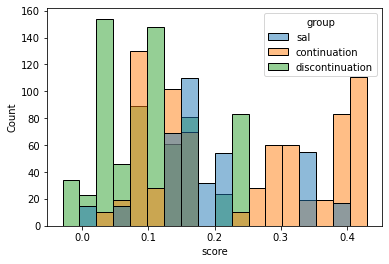

In [25]:
import seaborn as sns

(
    df_stats.merge(neurons[["session_name", "group"]].dropna())
    .pipe(lambda x: sns.histplot(data=x, x="score", hue="group"))
)

In [23]:
from citalopram_project.load import get_data_dir

derived_data_dir = get_data_dir() / "derived"
df_stats.to_parquet(derived_data_dir / "spont_ensemble_stats.parquet.gzip", compression="gzip")
df_ensembles.to_parquet(derived_data_dir / "spont_ensembles.parquet.gzip", compression="gzip")

In [5]:
def _reindex(df: pd.DataFrame, idx: np.ndarray) -> pd.DataFrame:
    df = df.reindex(idx)
    df = df[idx]
    return df


idx = []
for c in clusters:
    idx.extend(c)

df_corr2 = _reindex(df_corr, idx)

<AxesSubplot:>

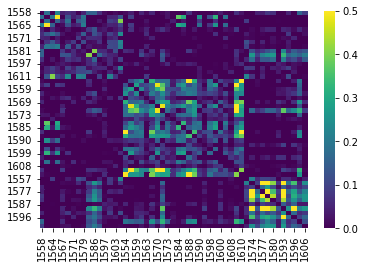

In [6]:
import seaborn as sns
sns.heatmap(df_corr2, vmin=0, vmax=0.5, cmap="viridis")

In [7]:
from citalopram_project.ensemble.humphries import communities_test


communities_test(df_corr, clusters, n_boot=1000)

(array([0.09689595, 0.17564577, 0.21201444]),
 array([0.00033333, 0.        , 0.        ]),
 array([0.06215781, 0.12717908, 0.17647139]))